In [10]:
#!/usr/bin/env python
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

# Load Google's pre-trained Word2Vec model
model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True) 
# has plural and upper/lower case, and even bigrams (e.g., taxpayer_dollars; vast_sums)

C:\Users\HP\AppData\Local\conda\conda\envs\py27\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [59]:
import LSA_and_LDA

Topic 0:
people like time good right did make way say really
Topic 1:
thanks mail advance hi looking info address email information help
Topic 2:
god jesus bible christ faith believe christians christian lord church
Topic 3:
key chip encryption clipper keys escrow government algorithm nsa public
Topic 4:
drive scsi drives disk hard ide controller floppy cd hd
Topic 5:
00 sale new offer shipping price 10 condition 50 asking
Topic 6:
windows file dos files use window program using problem running
Topic 7:
game team year games season players play hockey win league
Topic 8:
edu pitt gordon banks soon cs university article ftp cc
Topic 9:
car cars engine dealer miles speed driving good oil owner
Topic 10:
card video monitor drivers cards bus vga driver color ram
Topic 11:
does anybody mean work exist say info help exactly ftp
Topic 12:
don want mean oh sorry understand work care pretty read
Topic 13:
ve got seen heard tried recently good times noticed months
Topic 14:
just wondering like oh

## Part 1: play the game "Password"

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
wnl = WordNetLemmatizer()
sstm = SnowballStemmer("english")

In [13]:
# flex word2vec's muscles
model.doesnt_match("man woman child kitchen".split())
model.doesnt_match("france england germany berlin".split())
model.doesnt_match("paris berlin london austria".split())
model.most_similar("amsterdam")

# Consider a two-person task with a signaler and a receiver (similar to the TV gameshow 'Password'):
# The signalers were told that they would be playing a word-guessing game in which 
# they would have to think of one-word signals that would help someone guess their items. 
# They were talked through an example: if the item was 'dog', then a good signal would be 
# 'puppy' since most people given 'puppy' would probably guess 'dog'.

# sender thinks bank, says money
# receiver think cash
model.most_similar("bank") # .69 robber, .67 robbery, robbers, security, agency ..
model.most_similar("money") # .55 dollars, .55 profit, .54 cash
print(model.most_similar("cash")) # .69 capitalize, .54 money, sell, debt, tax


model['money']

print(model.similarity("hot","cold")) # .20
print(model.similarity("hot","warm")) # .14



[(u'money', 0.6151220798492432), (u'Cash', 0.5354235172271729), (u'cows_BCG_matrix', 0.5002977848052979), (u'funds', 0.48987293243408203), (u'marketable_securities', 0.473971962928772), (u'US1bn', 0.46651774644851685), (u'cash_flow', 0.4662739634513855), (u'sweepstakes_winnings', 0.46608874201774597), (u'shortstop_Pedro_Ciriaco', 0.46578019857406616), (u'$', 0.4635189175605774)]
0.46021386896123756
0.43215370794910785


In [14]:
def is_valid(word, password):
    """ check whether the hint is a valid hint
    
    word must not be part of another word, or contain hyphens/be more than two words"""
    lowerword = word.encode('ascii', errors='ignore').lower()
    lowerpass = password.encode('ascii', errors='ignore').lower()
    if lowerword == lowerpass:
        return False
    for char in '-_ ':
        if char in lowerword:
            return False
    if sstm.stem(lowerword)==sstm.stem(lowerpass):
        return False
    if wnl.lemmatize(lowerword) == wnl.lemmatize(lowerpass):
        return False
    return True

In [15]:
def send_word(secret, already_sent):
    """ Simulate a player trying to give hints.
    
    player tries words most similar to the password, if that fails, 
    words similar to the words similar to the password
    
    secret: the password to be guessed by the other player
    already_sent: list of words that have already been sent
    
    returns: a hint to the password, or None if it tried all words."""
    
    similars = model.most_similar(secret)  #find similar words
    for i in similars:
        if is_valid(i[0], secret):  # check if hint can be given
            if i[0] not in already_sent:
                return i[0]
            
    # words most similar to the password have failed
    sim_to_similars = model.most_similar(similars[0][0])  # find words similar
    for i in similars[1:]:                                # to words similar
        sim_to_similars += model.most_similar(i[0])       # to the password
    for i in sim_to_similars:  # send the words if they are valid
        if is_valid(i[0], secret):
            if i[0] not in already_sent:
                return i[0]
    return None  # no words were correct hints, system gives up

In [16]:
def receive_word(hint):
    """ simulate the player that has to guess the password.
    
    try to find the word most similar to the hint. check if that hint
    is valid, otherwise try a different word.
    
    TODO: improve guesses based on previous words."""
    similars = model.most_similar(hint)  # get most similar words to the hint
    for sim in similars:
        if is_valid(sim[0], hint):  # check whether word is valid
            return sim[0]
    return similars[0][0]  # if none of the words are valid, return the first guess

In [17]:
def play_password(password):
    """ method simulating a game of password
    
    for a given password, one player, that knows the password
    gives hints, the other player has to guess the password based
    on that word. After 100 tries it stops."""
    send_words = []
    for guessnr in range(100):
        send = send_word(password, send_words)
        send_words.append(send)
        if send is None:
            print "the method failed"
            return
        print send, receive_word(send)
        if password == receive_word(send):
            print "Found in {} guesses".format(guessnr+1)
            return
    print "the method failed"

In [19]:
passwords = ['cut', 'ice', 'stamp', 'self', 'snail', 'now',
'bed', 'night', 'needle', 'scratch', 'bank', 'joke', 'king', 'salt', 'good', 'washer', 'east', 'nail', 'bulb', 'lost']

for pw in passwords[1:3]:
    print "The password is {}".format(pw)
    play_password(pw)
    
    
    

The password is ice
icy snowy
snow snowfall
icesheets icesheet
Vatnajökull Vatnajokull
megacryometeor midlatitudes
snowy wintry
frigid chilly
wintry wintery
icey icy
slushy icy
frosty chilly
chilly frigid
Icy Slushy
slippery slippy
thaws melts
refreezes recrystalizes
melts evaporates
snowfall snow
snows snowfall
snowstorm blizzard
snowfalls snow
sleet snow
the method failed
the method failed
The password is stamp
semipostal stamps
commemoratives stamps
cachets stamps
sheetlet stamps
imprinted etched
affixed attached
embossed engraved
emblazoned stenciled
stencilled emblazoned
inscribed engraved
stenciled emblazoned
printed typeset
engraved inscribed
preaddressed prepaid_postage
Coin Numismatic
Philatelic Philately
Banknotes Coinage
Philately Philatelic
the method failed
the method failed


## Part two: representing the clustering of bodyparts in word2vec

In [40]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering as AC
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [43]:
print [1,2,3,4][1:]

[2, 3, 4]


In [ ]:
bodyparts = ["face", "nose", "mouth", "lips", "teeth", "tongue", "hand", "palm", "fingers", "pinky", "thumb", "leg", "arm", "head", "torso", "trunk", "bicep", "elbow", "forearm", "thigh", "knee", "ankle", "calf", "foot", "body"]
# for idx, part in enumerate(bodyparts):
#     print("{}: {}".format(idx, part))

# first value in list is what is higher in the hierarchy, other values are directly under the first
lvls = [[24, 13, 12, 11, 15, 14], 
        [13, 0], 
        [0, 1, 2 ,3], 
        [2, 4, 5], 
        [12, 17, 6, 18, 16],
        [6, 7, 8],
        [8, 9, 10],
        [11, 19, 20, 21, 22, 23]] 

bodymatrix = np.zeros((len(bodyparts), len(bodyparts)))
for lvl in lvls:
    for partx in lvl[1:]:
        # connect with higher part in hierarchy
        bodymatrix[lvl[0]][partx] = 0.4 + .2 * np.random.random()
        bodymatrix[partx][lvl[0]] = 0.4 + .2 * np.random.random()
        # connect with same level body part in hierarchy
        for party in lvl[1:]:
            bodymatrix[partx][party] = 0.8 + .2 * np.random.random()
        if partx==party:
            bodymatrix[partx][partx] = 1.
ground_truth_matrix = bodymatrix

In [81]:
# 
word2vec_matrix = np.zeros((len(bodyparts), len(bodyparts)))
for idx, i in enumerate(bodyparts):
    for idy, j in enumerate(bodyparts):
        if i == j:
            word2vec_matrix[idx][idy] = 1.
        else:
            word2vec_matrix[idx][idy] = model.similarity(i, j)

In [83]:
# part to try LSA. Failed for now
bodyparts = [unicode(part) for part in bodyparts]
LSA_matrix = np.zeros((len(bodyparts), len(bodyparts)))
for idx, i in enumerate(bodyparts):
    for idy, j in enumerate(bodyparts):
        if i == j:
            LSA_matrix[idx][idy] = 1.
        else:
            try:
                LSA_matrix[idx][idy] = 1. - (float(abs(LSA_and_LDA.tf_feature_names.index(i) - LSA_and_LDA.tf_feature_names.index(i)))/float(1.0*len(LSA_and_LDA.tfidf_feature_names)))
            except:
                LSA_matrix[idx][idy] = 0
print(LSA_matrix)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [51]:
ac = AC(n_clusters=2).fit(bodymatrix)

In [52]:
gt_linkage_matrix = linkage(bodymatrix, 'ward')
wv_linkage_matrix = linkage(word2vec_matrix, 'ward')

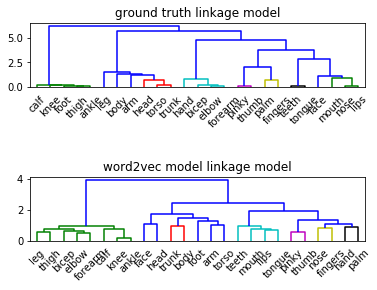

In [58]:
plt.figure(101)
plt.subplot(3,1,1)
plt.title("ground truth linkage model")
dg = dendrogram(gt_linkage_matrix,
           color_threshold=1,
           truncate_mode=None,
           labels=bodyparts,
           distance_sort=False)

plt.subplot(3,1,3)
plt.title("word2vec model linkage model")
dg = dendrogram(wv_linkage_matrix,
           color_threshold=1,
           truncate_mode=None,
           labels=bodyparts,
           distance_sort=False)